# Kernel Ridge Regression vs SchNet: data efficiency

The molecular trajectory datasets that we use to train a dipolar moment prediction model are generated through expensive simulations. Therefore, the ability of a family of models to learn from small datasets is of interest. This work will compare the performance of a Kernel Ridge Regression (KRR) model and SchNet model for datasets of size between 10 and 100 points. Each subsequent dataset will be a superset of the previous, with the whole training set of 100 points being randomly sampled.

In [1]:
import os

import numpy as onp
import jax.numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GridSearchCV

from dipole import VectorValuedKRR
from utils import matern, coulomb

In [2]:
data = np.load('data/HOOH.DFT.PBE-TS.light.MD.500K.50k.R_E_F_D_Q.npz')
X = np.array(data['R'])
y = np.array(data['D'])

In [3]:
import schnetpack as spk
from ase.db.jsondb import JSONDatabase
from schnetpack.data import AtomsData
atomsdb = AtomsData('data/data.json')
M = len(atomsdb)
print(M)

2000


In [4]:
import torch
import schnetpack as spk

# loss function
def squared_norm(batch, result):
    diff = batch['dipole'].squeeze() - result['dipole'].squeeze()
    err_sq = torch.linalg.norm(diff, axis=1)**2
    return err_sq.mean().item()


def train_schnet(train, val, size=50):

    train_loader = spk.AtomsLoader(train, batch_size=2048, shuffle=True)
    val_loader = spk.AtomsLoader(val, batch_size=2048)

    schnet = spk.representation.SchNet(
        n_atom_basis=30, n_filters=30, n_gaussians=20, n_interactions=5,
        cutoff=4., cutoff_network=spk.nn.cutoff.CosineCutoff
    )

    output_alpha = spk.atomistic.DipoleMoment(n_in=30, property='dipole')
    model = spk.AtomisticModel(representation=schnet, output_modules=output_alpha)

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
    loss = spk.train.build_mse_loss(['dipole'])

    metrics = [spk.metrics.MeanAbsoluteError('dipole')]
    hooks = [
        spk.train.ReduceLROnPlateauHook(
            optimizer,
            patience=5, factor=0.8, min_lr=1e-6,
            stop_after_min=True
        ),
        spk.train.EarlyStoppingHook(8)
    ]

    model_dir = f'model-{size}'
    trainer = spk.train.Trainer(
        model_path=model_dir,
        model=model,
        hooks=hooks,
        loss_fn=loss,
        optimizer=optimizer,
        train_loader=train_loader,
        validation_loader=val_loader,
    )

    trainer.train(device='cpu', n_epochs=50)

    return torch.load(os.path.join(model_dir, 'best_model'))

In [5]:
data_subset_sizes = list(np.linspace(10, 100, 10, dtype=int))
sigmas = list(np.logspace(1, 4, 19))
lambdas = list(np.logspace(0, 3, 10))
parameters = {'sigma': sigmas, 'lamb': lambdas}

test_indices = onp.random.choice(M, size=100, replace=False)
test_data = atomsdb.create_subset(list(test_indices))
test_batch = list(spk.AtomsLoader(test_data, batch_size=2048))[0]
Xtest, ytest = X[test_indices], y[test_indices]

mask = onp.ones(M, dtype=bool)
mask[test_indices] = False
X, y = X[mask], y[mask]

train_indices = onp.random.choice(M-100, size=data_subset_sizes[-1], replace=False)
X, y = X[train_indices], y[train_indices]

errors_gdml, errors_schnet = [], []

for size in data_subset_sizes:
    print(f'size: {size}')

    Xtrain, ytrain = X[:size], y[:size]

    cross_validation = GridSearchCV(VectorValuedKRR(), parameters)
    cross_validation.fit(Xtrain, ytrain)
    results = cross_validation.cv_results_
    best = np.argmin(results['rank_test_score'])
    best_params = results['params'][best]
    # print(f'best params: {best_params}')
    best_model = VectorValuedKRR(**best_params)
    best_model.fit(Xtrain, ytrain)
    best_test_error = -best_model.score(Xtest, ytest).item()
    errors_gdml.append(best_test_error)
    print(f'gdml error: {best_test_error:.6f}')

    data_cut = atomsdb.create_subset(train_indices[:size])
    val_size = size // 10
    train, val, test = spk.train_test_split(
        data=data_cut,
        num_train=size - val_size,
        num_val=val_size
    )
    best_model = train_schnet(train, val, size=size)
    prediction = best_model(test_batch)
    test_error_schnet = squared_norm(prediction, test_batch)
    print(f'schnet error: {test_error_schnet:.6f}')
    errors_schnet.append(test_error_schnet)


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/jax/_src/lax/lax.py:6271: UserWarning: Explicitly requested dtype <class 'int'> requested in linspace is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ase/atoms.py:972: VisibleDeprecationWarning: Use get_global_number_of_atoms() instead
  np.VisibleDeprecationWarning)


size: 10
gdml error: 0.429327
schnet error: 0.022477
size: 20
gdml error: 0.029824
schnet error: 0.006545
size: 30
gdml error: 0.097247
schnet error: 0.195346
size: 40
gdml error: 0.033223
schnet error: 0.189256
size: 50
gdml error: 0.038128
schnet error: 0.001093
size: 60
gdml error: 0.045432
schnet error: 0.162942
size: 70
gdml error: 0.026639
schnet error: 0.119751
size: 80
gdml error: 0.034595
schnet error: 0.180008
size: 90
gdml error: 0.116423
schnet error: 0.149139
size: 100
gdml error: 0.032114
schnet error: 0.200092


<AxesSubplot:label='4b0b5a1e-5be8-4df0-829f-053b9179e89c', xlabel='samples trained on', ylabel='schnet error'>

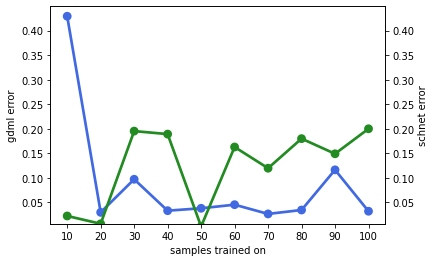

In [6]:
data = pd.DataFrame({'samples trained on': data_subset_sizes, 'gdml error': errors_gdml, 'schnet error': errors_schnet})
fig, ax = plt.subplots()
ax2 = ax.twinx()
sns.pointplot(x='samples trained on', y='gdml error', data=data, s=100, ax=ax, color='royalblue')
ax2.set_ylim(ax.get_ylim())
sns.pointplot(x='samples trained on', y='schnet error', data=data, s=100, ax=ax2, color='forestgreen')

As seen on the plot, our method (blue) usually outperforms a deep SchNet model on a small training set. 